In [6]:
# Ячейка 1: Загрузка обученной модели
import sys
sys.path.append('..')

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

from src.model import SimpleDenoisingCNN
from src.dataset import STEM4DDataset

device = torch.device('cpu')
results_path = Path("../results")

# Загрузка модели
model = SimpleDenoisingCNN(in_channels=8).to(device)
checkpoint = torch.load(results_path / 'checkpoints' / 'best_model.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch']}")
print(f"Validation metrics: {checkpoint['val_metrics']}")

Loaded model from epoch 16
Validation metrics: {'mse': np.float64(35.89434499870593), 'psnr': np.float64(20.057811699244464), 'ssim': np.float64(0.7295925113495989), 'correlation': np.float64(0.7593207051319704)}


In [16]:
# Ячейка 2: Функция деноизинга
def denoise_full_dataset_simple(model, noisy_data, bf_mask=None, 
                               batch_size=64, device='cpu'):
    """Упрощенная версия без использования info из DataLoader"""
    scan_x, scan_y, det_x, det_y = noisy_data.shape
    denoised = np.zeros_like(noisy_data)
    
    # Создаем список всех валидных позиций
    offset = 1  # для окна 3x3
    valid_positions = []
    for x in range(offset, scan_x - offset):
        for y in range(offset, scan_y - offset):
            valid_positions.append((x, y))
    
    # Обрабатываем батчами
    model.eval()
    with torch.no_grad():
        for batch_start in tqdm(range(0, len(valid_positions), batch_size), 
                               desc='Denoising'):
            batch_end = min(batch_start + batch_size, len(valid_positions))
            batch_positions = valid_positions[batch_start:batch_end]
            
            # Собираем входные данные для батча
            batch_inputs = []
            for x, y in batch_positions:
                neighbors = []
                for i in range(3):
                    for j in range(3):
                        if i == 1 and j == 1:
                            continue  # Пропускаем центр
                        nx, ny = x - 1 + i, y - 1 + j
                        pattern = noisy_data[nx, ny]
                        if bf_mask is not None:
                            pattern = pattern * bf_mask
                        neighbors.append(pattern)
                
                batch_inputs.append(np.stack(neighbors))
            
            # Преобразуем в тензор и применяем модель
            inputs = torch.FloatTensor(np.stack(batch_inputs)).to(device)
            outputs = model(inputs)
            
            # Сохраняем результаты
            for i, (x, y) in enumerate(batch_positions):
                denoised[x, y] = outputs[i, 0].cpu().numpy()
    
    # Обработка краев
    denoised[0, :] = noisy_data[0, :]
    denoised[-1, :] = noisy_data[-1, :]
    denoised[:, 0] = noisy_data[:, 0]
    denoised[:, -1] = noisy_data[:, -1]
    
    return denoised

In [17]:
# Ячейка 3: Применение деноизинга
# Загрузка данных
data_path = Path("../data")
low_dose = np.load(data_path / "03_denoising_SrTiO3_High_mag_Low_dose.npy")
high_dose = np.load(data_path / "03_denoising_SrTiO3_High_mag_High_dose.npy")

# Bright field mask
pacbed = np.mean(high_dose, axis=(0, 1))
bf_mask = pacbed > (0.1 * pacbed.max())

# Деноизинг
print("Applying denoising to full dataset...")
denoised_data = denoise_full_dataset_simple(
    model, low_dose, bf_mask=bf_mask, device=device
)

# Сохранение результата
np.save(results_path / 'denoised_data.npy', denoised_data)
print("Denoised data saved!")

Applying denoising to full dataset...


Denoising: 100%|██████████| 1009/1009 [02:17<00:00,  7.36it/s]


Denoised data saved!


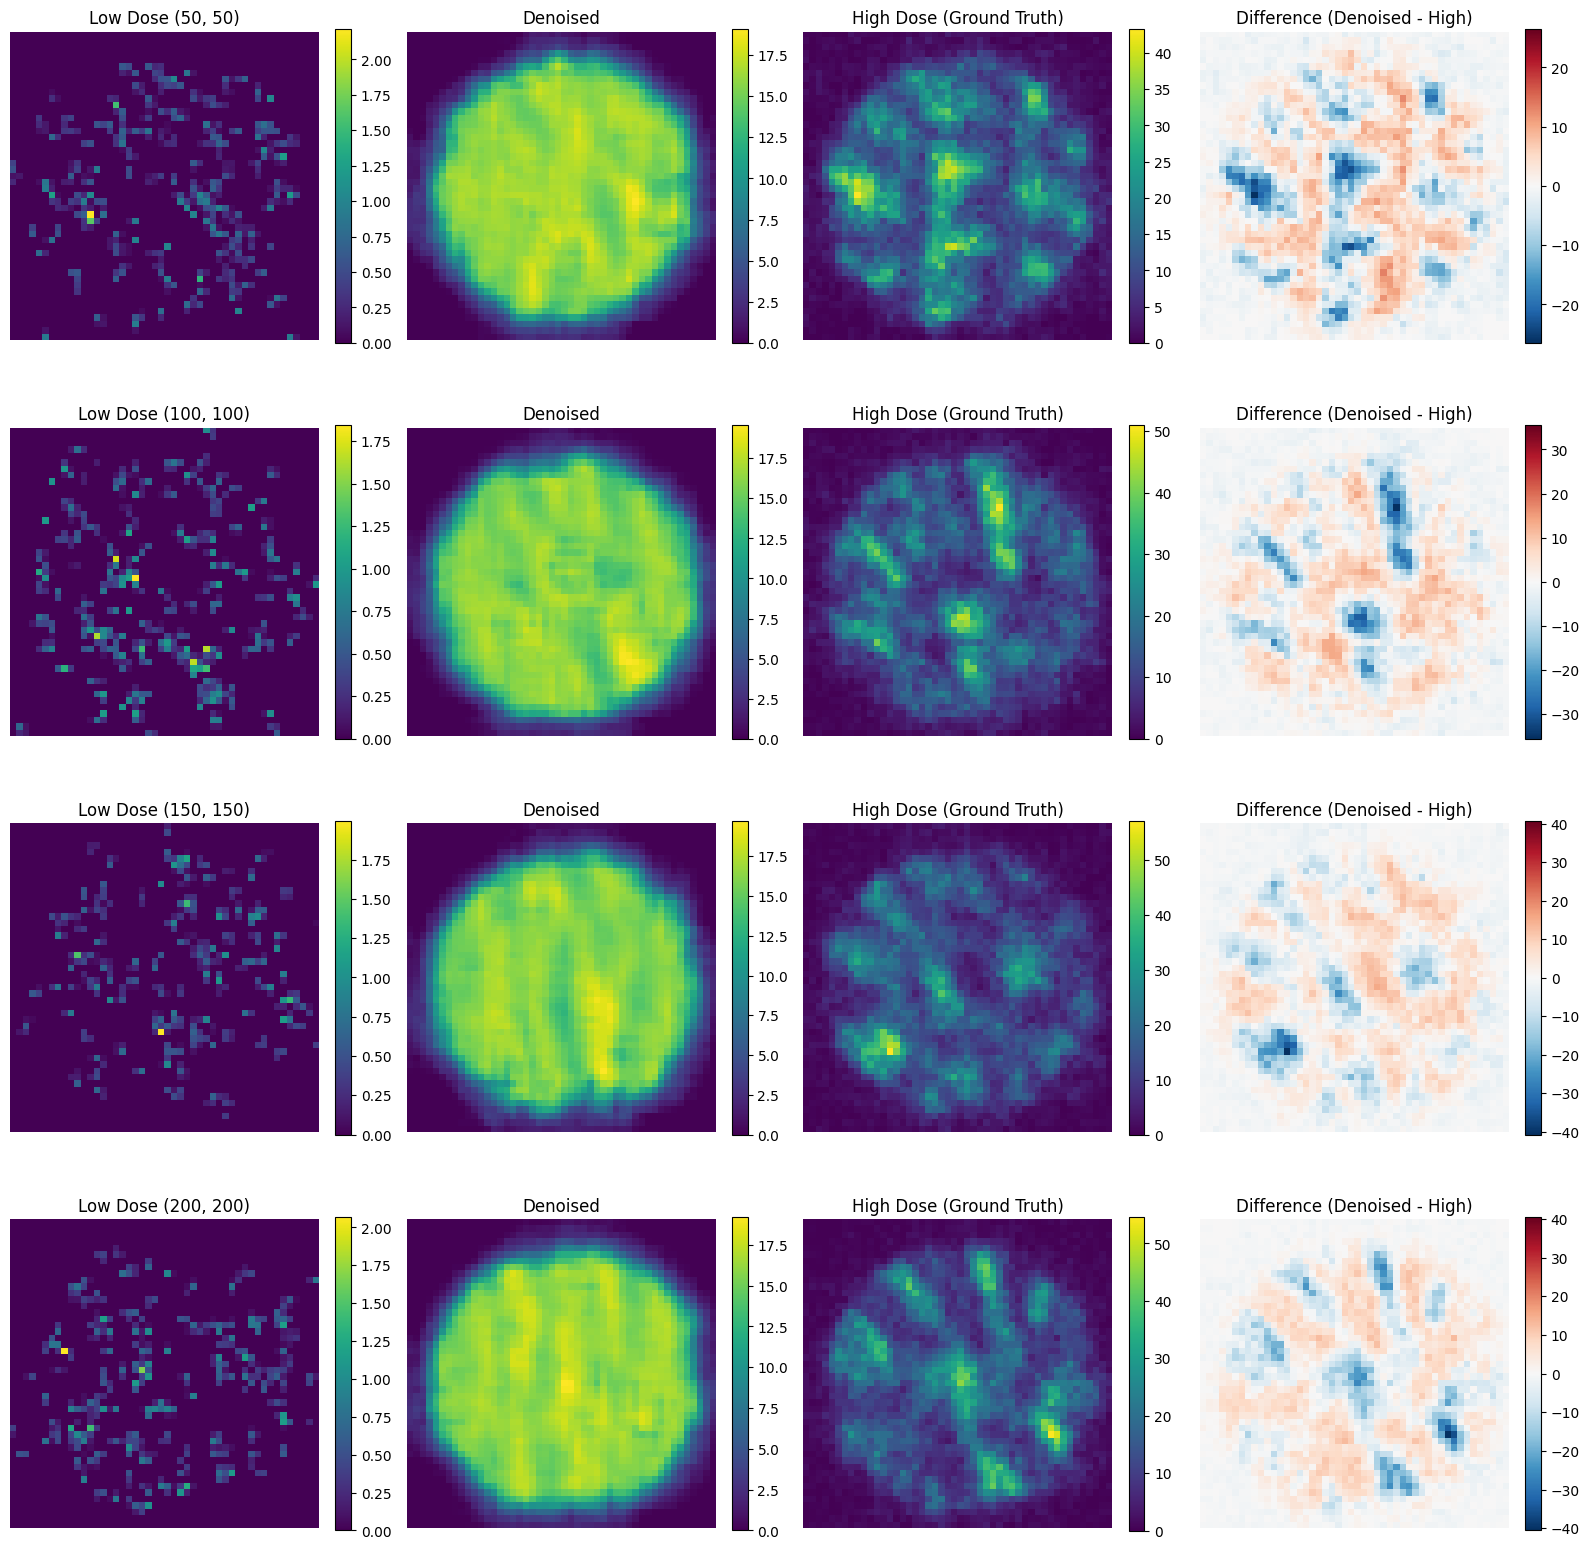

In [18]:
# Ячейка 4: Визуализация результатов
def plot_denoising_results(low, high, denoised, positions):
    """Сравнение результатов деноизинга"""
    n_examples = len(positions)
    fig, axes = plt.subplots(n_examples, 4, figsize=(16, 4*n_examples))
    
    if n_examples == 1:
        axes = axes.reshape(1, -1)
    
    for i, (x, y) in enumerate(positions):
        # Low dose
        im1 = axes[i, 0].imshow(low[x, y], cmap='viridis')
        axes[i, 0].set_title(f'Low Dose ({x}, {y})')
        axes[i, 0].axis('off')
        plt.colorbar(im1, ax=axes[i, 0], fraction=0.046)
        
        # Denoised
        im2 = axes[i, 1].imshow(denoised[x, y], cmap='viridis')
        axes[i, 1].set_title('Denoised')
        axes[i, 1].axis('off')
        plt.colorbar(im2, ax=axes[i, 1], fraction=0.046)
        
        # High dose
        im3 = axes[i, 2].imshow(high[x, y], cmap='viridis')
        axes[i, 2].set_title(f'High Dose (Ground Truth)')
        axes[i, 2].axis('off')
        plt.colorbar(im3, ax=axes[i, 2], fraction=0.046)
        
        # Difference
        diff = denoised[x, y] - high[x, y]
        vmax = np.abs(diff).max()
        im4 = axes[i, 3].imshow(diff, cmap='RdBu_r', 
                               vmin=-vmax, vmax=vmax)
        axes[i, 3].set_title('Difference (Denoised - High)')
        axes[i, 3].axis('off')
        plt.colorbar(im4, ax=axes[i, 3], fraction=0.046)
    
    plt.tight_layout()
    return fig

# Выбираем несколько позиций для визуализации
positions = [(50, 50), (100, 100), (150, 150), (200, 200)]
fig = plot_denoising_results(low_dose, high_dose, denoised_data, positions)
fig.savefig(results_path / 'figures' / 'denoising_examples.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Ячейка 5: Количественная оценка
def evaluate_denoising_quality(denoised, ground_truth, mask=None):
    """Оценка качества деноизинга"""
    if mask is not None:
        denoised_masked = denoised * mask[None, None, :, :]
        gt_masked = ground_truth * mask[None, None, :, :]
    else:
        denoised_masked = denoised
        gt_masked = ground_truth
    
    # Flatten для статистики
    denoised_flat = denoised_masked.flatten()
    gt_flat = gt_masked.flatten()
    
    # Удаляем нули (вне маски)
    valid = gt_flat > 0
    denoised_flat = denoised_flat[valid]
    gt_flat = gt_flat[valid]
    
    # MSE
    mse = np.mean((denoised_flat - gt_flat) ** 2)
    
    # PSNR
    max_val = gt_flat.max()
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    
    # Correlation
    correlation = np.corrcoef(denoised_flat, gt_flat)[0, 1]
    
    # SSIM (упрощенная глобальная версия)
    mean_d = denoised_flat.mean()
    mean_gt = gt_flat.mean()
    std_d = denoised_flat.std()
    std_gt = gt_flat.std()
    cov = np.mean((denoised_flat - mean_d) * (gt_flat - mean_gt))
    
    c1 = (0.01 * max_val) ** 2
    c2 = (0.03 * max_val) ** 2
    
    ssim = ((2 * mean_d * mean_gt + c1) * (2 * cov + c2)) / \
           ((mean_d ** 2 + mean_gt ** 2 + c1) * (std_d ** 2 + std_gt ** 2 + c2))
    
    return {
        'mse': mse,
        'psnr': psnr,
        'correlation': correlation,
        'ssim': ssim
    }

# Оценка на всем датасете
print("Evaluating denoising quality...")
metrics = evaluate_denoising_quality(denoised_data, high_dose, mask=bf_mask)

print("\nDenoising Quality Metrics:")
print(f"  MSE: {metrics['mse']:.4f}")
print(f"  PSNR: {metrics['psnr']:.2f} dB")
print(f"  Correlation: {metrics['correlation']:.4f}")
print(f"  SSIM: {metrics['ssim']:.4f}")

# Сравнение с исходными данными
metrics_original = evaluate_denoising_quality(low_dose, high_dose, mask=bf_mask)
print("\nOriginal Low Dose vs High Dose:")
print(f"  MSE: {metrics_original['mse']:.4f}")
print(f"  PSNR: {metrics_original['psnr']:.2f} dB")
print(f"  Correlation: {metrics_original['correlation']:.4f}")
print(f"  SSIM: {metrics_original['ssim']:.4f}")

improvement = {
    'psnr': metrics['psnr'] - metrics_original['psnr'],
    'correlation': metrics['correlation'] - metrics_original['correlation'],
    'ssim': metrics['ssim'] - metrics_original['ssim']
}
print(f"\nImprovement:")
print(f"  PSNR: +{improvement['psnr']:.2f} dB")
print(f"  Correlation: +{improvement['correlation']:.4f}")
print(f"  SSIM: +{improvement['ssim']:.4f}")

Evaluating denoising quality...

Denoising Quality Metrics:
  MSE: 48.1532
  PSNR: 21.67 dB
  Correlation: 0.5947
  SSIM: 0.5684

Original Low Dose vs High Dose:
  MSE: 227.9536
  PSNR: 14.92 dB
  Correlation: 0.1069
  SSIM: 0.0016

Improvement:
  PSNR: +6.75 dB
  Correlation: +0.4878
  SSIM: +0.5668


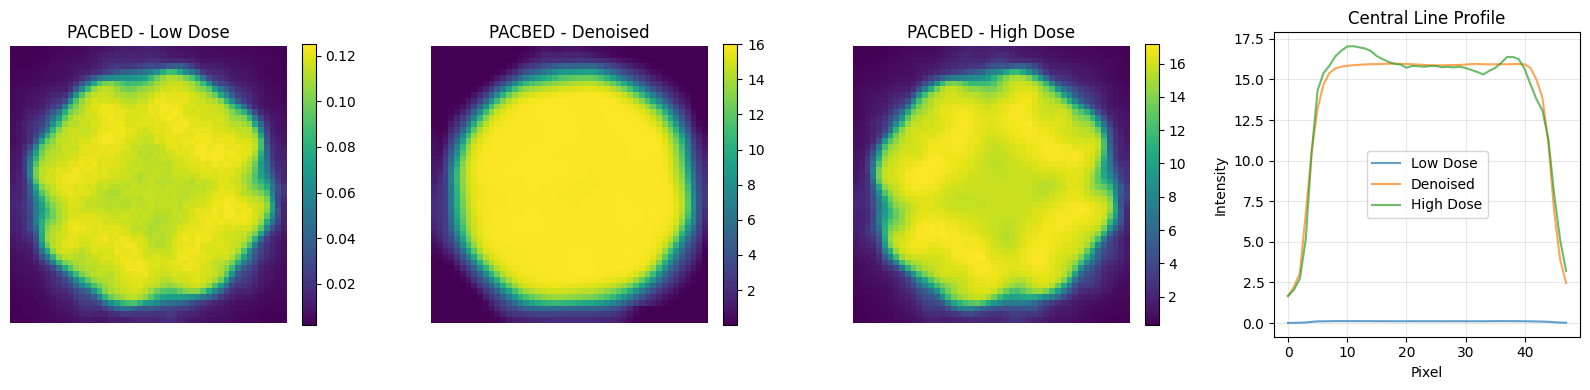

In [20]:
# Ячейка 6: Анализ PACBED
# PACBED comparison
pacbed_low = np.mean(low_dose, axis=(0, 1))
pacbed_high = np.mean(high_dose, axis=(0, 1))
pacbed_denoised = np.mean(denoised_data, axis=(0, 1))

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Low dose PACBED
im1 = axes[0].imshow(pacbed_low, cmap='viridis')
axes[0].set_title('PACBED - Low Dose')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046)

# Denoised PACBED
im2 = axes[1].imshow(pacbed_denoised, cmap='viridis')
axes[1].set_title('PACBED - Denoised')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046)

# High dose PACBED
im3 = axes[2].imshow(pacbed_high, cmap='viridis')
axes[2].set_title('PACBED - High Dose')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2], fraction=0.046)

# Line profiles
center = pacbed_high.shape[0] // 2
axes[3].plot(pacbed_low[center, :], label='Low Dose', alpha=0.7)
axes[3].plot(pacbed_denoised[center, :], label='Denoised', alpha=0.7)
axes[3].plot(pacbed_high[center, :], label='High Dose', alpha=0.7)
axes[3].set_xlabel('Pixel')
axes[3].set_ylabel('Intensity')
axes[3].set_title('Central Line Profile')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_path / 'figures' / 'pacbed_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()